<a href="https://colab.research.google.com/github/Max-JI64/Kakao_Tech_Bootcamp/blob/main/Assignment/week7/7%EC%A3%BC%EC%B0%A8%EA%B3%BC%EC%A0%9C3_max_ji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리

In [ ]:
import numpy as np
import os
import torch
import random
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import time
from sklearn.metrics import f1_score

In [ ]:
#재현성 고정
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # multi-GPU 환경
    torch.backends.cudnn.deterministic = True  # 완전 재현을 원할 때
    torch.backends.cudnn.benchmark = False     # GPU 최적화 탐색 비활성 (불확실성 제거)
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"[Seed fixed to {seed}]")

# CIFAR-10 데이터셋

In [ ]:
# CIFAR-10 불러오기
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

# 정규화
x_train_full = x_train_full.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0

# train: 40,000 / val: 10,000 / test: 1,000 분리
x_train = x_train_full[:40000]
y_train = y_train_full[:40000]

x_val = x_train_full[40000:50000]
y_val = y_train_full[40000:50000]

# 원-핫 인코딩
y_train = to_categorical(y_train, 10)
y_val   = to_categorical(y_val, 10)
y_test  = to_categorical(y_test, 10)

# 확인
print("Train:", x_train.shape, y_train.shape)
print("Val  :", x_val.shape, y_val.shape)
print("Test :", x_test.shape, y_test.shape)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Train: (40000, 32, 32, 3) (40000, 10)
Val  : (10000, 32, 32, 3) (10000, 10)
Test : (10000, 32, 32, 3) (10000, 10)


# I. ResNet32 CIFAR-10 학습

## Residual block

In [ ]:
def residual_block(x, filters, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, 3, stride, padding='same', use_bias=False,
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, 1, padding='same', use_bias=False,
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    # downsampling shortcut when dimension changes
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, stride, use_bias=False,
                                 kernel_initializer='he_normal')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

## ResNet32 모델 생성

In [ ]:
def ResNet32_CIFAR10(input_shape=(32, 32, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, 3, 1, padding='same', use_bias=False,
                      kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # stage1: 5 residual blocks, 16 filters
    for _ in range(5):
        x = residual_block(x, 16)

    # stage2: 5 residual blocks, 32 filters, first block stride=2
    x = residual_block(x, 32, stride=2)
    for _ in range(4):
        x = residual_block(x, 32)

    # stage3: 5 residual blocks, 64 filters, first block stride=2
    x = residual_block(x, 64, stride=2)
    for _ in range(4):
        x = residual_block(x, 64)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax',
                           kernel_initializer='he_normal')(x)

    model = models.Model(inputs, outputs, name='ResNet32_CIFAR10')
    return model

In [ ]:
model_resnet = ResNet32_CIFAR10()
model_resnet.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_resnet.summary()

Model: "ResNet32_CIFAR10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        432 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      2,304 │ re_lu[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      2,304 │ re_lu_1[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ add[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      2,304 │ re_lu_2[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      2,304 │ re_lu_3[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 469,370 (1.79 MB)

 Trainable params: 466,906 (1.78 MB)

 Non-trainable params: 2,464 (9.62 KB)

## 학습

In [ ]:
resnet_start_time = time.time()

resnet_train_loss, resnet_val_loss = [], []
resnet_train_acc, resnet_val_acc = [], []
resnet_train_f1, resnet_val_f1 = [], []

EPOCHS = 30
BATCH_SIZE = 64

#f1-score를 구하기 위하여 한 에포크마다 학습을 진행한다
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")

    history_resnet = model_resnet.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=1,
        batch_size=BATCH_SIZE,
        verbose=1
    )

    #손실, 정확도 저장
    resnet_train_loss.append(history_resnet.history['loss'][0])
    resnet_val_loss.append(history_resnet.history['val_loss'][0])
    resnet_train_acc.append(history_resnet.history['accuracy'][0])
    resnet_val_acc.append(history_resnet.history['val_accuracy'][0])

    #F1-score 계산
    y_pred_train = np.argmax(model_resnet.predict(x_train, verbose=0), axis=1)
    y_true_train = np.argmax(y_train, axis=1)
    y_pred_val = np.argmax(model_resnet.predict(x_val, verbose=0), axis=1)
    y_true_val = np.argmax(y_val, axis=1)
    f1_train = f1_score(y_true_train, y_pred_train, average='macro')
    f1_val = f1_score(y_true_val, y_pred_val, average='macro')
    ##저장
    resnet_train_f1.append(f1_train)
    resnet_val_f1.append(f1_val)


resnet_total_time = time.time() - resnet_start_time

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 17ms/step - accuracy: 0.3787 - loss: 1.7207 - val_accuracy: 0.5064 - val_loss: 1.3998
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6157 - loss: 1.0885 - val_accuracy: 0.5500 - val_loss: 1.3916
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6893 - loss: 0.8709 - val_accuracy: 0.5923 - val_loss: 1.2439
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7430 - loss: 0.7276 - val_accuracy: 0.6336 - val_loss: 1.1414
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7876 - loss: 0.6068 - val_accuracy: 0.6951 - val_loss: 0.9097
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8164 - loss: 0.5236 - val_accuracy: 0.7391 - val_loss: 0.7688
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8419 - loss: 0.4486 - val_accuracy: 0.7140 - val_loss: 0.8778
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8650 - loss: 0.3865 - val_acc

## 테스트 평가

In [ ]:
resnet_test_loss, resnet_test_acc = model_resnet.evaluate(x_test, y_test, verbose=1)

#f1-score
y_pred_resnet = np.argmax(model_resnet.predict(x_test, verbose=0), axis=1)
y_true_resnet = np.argmax(y_test, axis=1)
resnet_test_f1 = f1_score(y_true_resnet, y_pred_resnet, average='macro')

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7567 - loss: 1.3009


# II. VGG16 CIFAR-10 학습

## VGG16 모델 생성

In [ ]:
base_vgg = tf.keras.applications.VGG16(include_top=False, weights=None, input_shape=(32,32,3))
base_vgg.trainable = True

model_vgg = tf.keras.Sequential([
    base_vgg,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model_vgg.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_resnet.summary()

Model: "ResNet32_CIFAR10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        432 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      2,304 │ re_lu[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      2,304 │ re_lu_1[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ add[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      2,304 │ re_lu_2[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      2,304 │ re_lu_3[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 1,403,184 (5.35 MB)

 Trainable params: 466,906 (1.78 MB)

 Non-trainable params: 2,464 (9.62 KB)

 Optimizer params: 933,814 (3.56 MB)

## 학습

In [ ]:
vgg_start_time = time.time()

vgg_train_loss, vgg_val_loss = [], []
vgg_train_acc, vgg_val_acc = [], []
vgg_train_f1, vgg_val_f1 = [], []

EPOCHS = 30
BATCH_SIZE = 64

#f1-score를 구하기 위하여 한 에포크마다 학습을 진행한다
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")

    history_vgg = model_vgg.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=1,
        batch_size=BATCH_SIZE,
        verbose=1
    )

    #손실, 정확도 저장
    vgg_train_loss.append(history_vgg.history['loss'][0])
    vgg_val_loss.append(history_vgg.history['val_loss'][0])
    vgg_train_acc.append(history_vgg.history['accuracy'][0])
    vgg_val_acc.append(history_vgg.history['val_accuracy'][0])

    #F1-score 계산
    y_pred_train = np.argmax(model_vgg.predict(x_train, verbose=0), axis=1)
    y_true_train = np.argmax(y_train, axis=1)
    y_pred_val = np.argmax(model_vgg.predict(x_val, verbose=0), axis=1)
    y_true_val = np.argmax(y_val, axis=1)
    f1_train = f1_score(y_true_train, y_pred_train, average='macro')
    f1_val = f1_score(y_true_val, y_pred_val, average='macro')
    ##저장
    vgg_train_f1.append(f1_train)
    vgg_val_f1.append(f1_val)


vgg_total_time = time.time() - vgg_start_time

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - accuracy: 0.0989 - loss: 2.3032 - val_accuracy: 0.0980 - val_loss: 2.3028
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.0994 - loss: 2.3027 - val_accuracy: 0.0980 - val_loss: 2.3027
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.1010 - loss: 2.3027 - val_accuracy: 0.0952 - val_loss: 2.3028
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.1006 - loss: 2.3027 - val_accuracy: 0.0952 - val_loss: 2.3027
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.0987 - loss: 2.3027 - val_accuracy: 0.0952 - val_loss: 2.3028
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.1005 - loss: 2.3027 - val_accuracy: 0.0952 - val_loss: 2.3027
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.1006 - loss: 2.3027 - val_accuracy: 0.0952 - val_loss: 2.3027
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.1012 - loss: 2.3027 - 

## 테스트 평가

In [ ]:
vgg_test_loss, vgg_test_acc = model_vgg.evaluate(x_test, y_test, verbose=1)

#f1-score
y_pred_vgg = np.argmax(model_vgg.predict(x_test, verbose=0), axis=1)
y_true_vgg = np.argmax(y_test, axis=1)
vgg_test_f1 = f1_score(y_true_vgg, y_pred_vgg, average='macro')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0968 - loss: 2.3026


# III. 모델 비교

## 성능 비교표

In [ ]:
import pandas as pd
result = {
    "total_parameters": [model_resnet.count_params(), model_vgg.count_params()],
    "trainable_parameters": [np.sum([tf.keras.backend.count_params(w) for w in model_resnet.trainable_weights]), np.sum([tf.keras.backend.count_params(w) for w in model_vgg.trainable_weights])],

    "val_best_loss": [np.min(resnet_val_loss), np.min(vgg_val_loss)],
    "val_best_accuracy": [np.max(resnet_val_acc), np.max(vgg_val_acc)],
    "val_best_f1": [np.max(resnet_val_f1), np.max(vgg_val_f1)],

    "test_loss":[resnet_test_loss, vgg_test_loss],
    "test accurecy":[resnet_test_acc, vgg_test_acc],
    "test_f1_score": [resnet_test_f1, vgg_test_f1],

    "train_time(s)": [resnet_total_time, vgg_total_time]
    }
result_df = pd.DataFrame(result, index=["ResNet32", "VGG16"]).T.round(2)
result_df


,ResNet32,VGG16
total_parameters,469370.00,14848586.00
trainable_parameters,466906.00,14848586.00
val_best_loss,0.74,2.30
val_best_accuracy,0.78,0.10
val_best_f1,0.78,0.02
test_loss,1.32,2.30
test accurecy,0.76,0.10
test_f1_score,0.76,0.02
train_time(s),446.20,730.22


## 손실, 정확도 학습 곡선

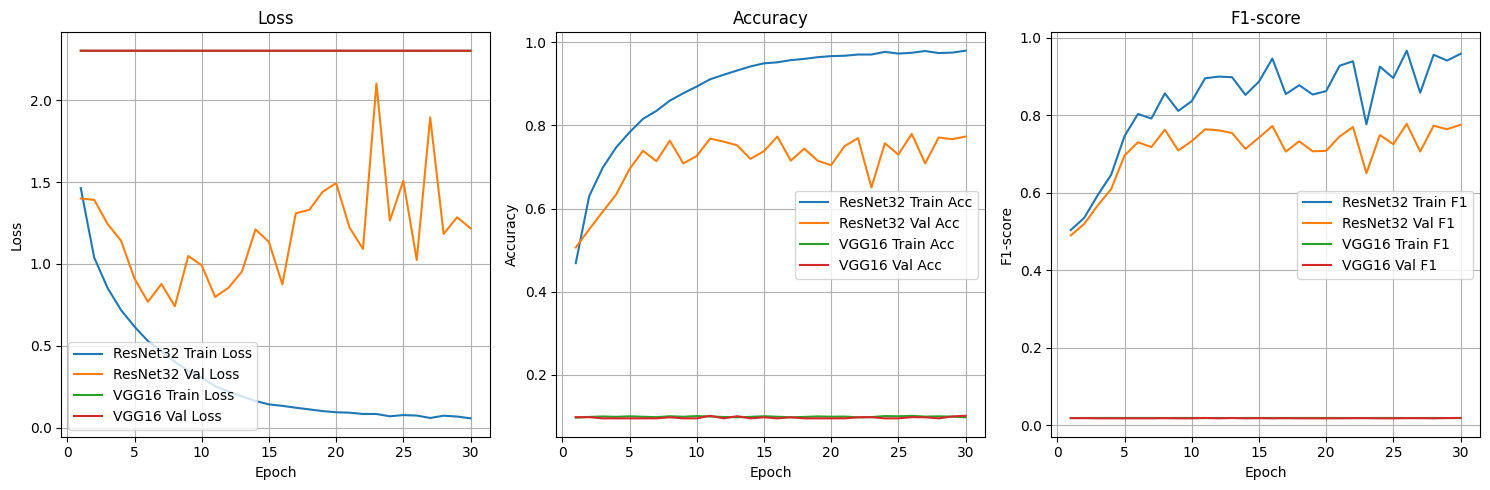

In [ ]:
epochs = np.arange(1, EPOCHS + 1)

plt.figure(figsize=(15, 5))

# (1) Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, resnet_train_loss, label='ResNet32 Train Loss')
plt.plot(epochs, resnet_val_loss, label='ResNet32 Val Loss')
plt.plot(epochs, vgg_train_loss, label='VGG16 Train Loss')
plt.plot(epochs, vgg_val_loss, label='VGG16 Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# (2) Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, resnet_train_acc, label='ResNet32 Train Acc')
plt.plot(epochs, resnet_val_acc, label='ResNet32 Val Acc')
plt.plot(epochs, vgg_train_acc, label='VGG16 Train Acc')
plt.plot(epochs, vgg_val_acc, label='VGG16 Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# (3) F1-score
plt.subplot(1, 3, 3)
plt.plot(epochs, resnet_train_f1, label='ResNet32 Train F1')
plt.plot(epochs, resnet_val_f1, label='ResNet32 Val F1')
plt.plot(epochs, vgg_train_f1, label='VGG16 Train F1')
plt.plot(epochs, vgg_val_f1, label='VGG16 Val F1')
plt.title('F1-score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()